# First ICU & 5 Day Discharge Prediction using Logistic Regression

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
import pickle
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import interp, stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

from utils.splits import set_two_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *
from args import args
vars(args)

{'path': PosixPath('../data'),
 'workdir': PosixPath('../data/workdir/lr'),
 'dataset_csv': PosixPath('../data/mimic_icu_pred_proc_dataset.csv'),
 'cols': ['imminent_label', 'discharge_label', 'scispacy_note'],
 'modeldir': PosixPath('../data/workdir/lr/models'),
 'min_freq': 3,
 'imminent_threshold': 0.47,
 'discharge_threshold': 0.48,
 'start_seed': 127}

In [3]:
seed = 42
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols)

imminent_df = ori_df.loc[(ori_df['imminent_label'] != -1)][['scispacy_note', 'imminent_label']].reset_index()
discharge_df = ori_df[['scispacy_note', 'discharge_label']].reset_index()

## LR Model Dev

### Imminent ICU Admission

In [4]:
df = set_two_splits(imminent_df.copy(), 'test', seed=seed)
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['scispacy_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['scispacy_note'])
y_train = df.loc[(df['split'] == 'train')]['imminent_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['imminent_label'].to_numpy()

In [5]:
clf = LogisticRegression(dual=True, class_weight='balanced', solver='liblinear', C=1.5, multi_class='ovr')
clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plot_thresh_range(ax, y_test, prob, 0.3, 0.7, 25)

In [6]:
args.imminent_threshold = 0.47
y_pred = (prob > args.imminent_threshold).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
prevalence = (fn+tp)/(tn+fp+fn+tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'prevalence': np.round(prevalence, 3),  
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.834
specificity,0.749
ppv,0.512
npv,0.934
f1,0.635
auroc,0.867
prevalence,0.240


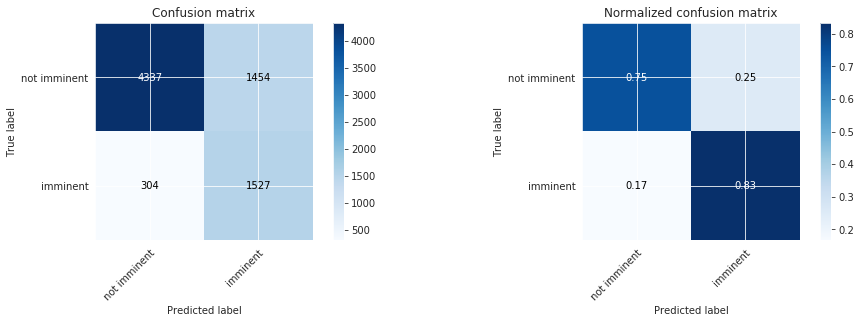

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_confusion_matrix(ax[0], cm, classes=['not imminent', 'imminent'], normalize=False, title='Confusion matrix')
plot_confusion_matrix(ax[1], cm, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized confusion matrix')
plt.show()

Text(0.5, 1.0, 'Positive Class')

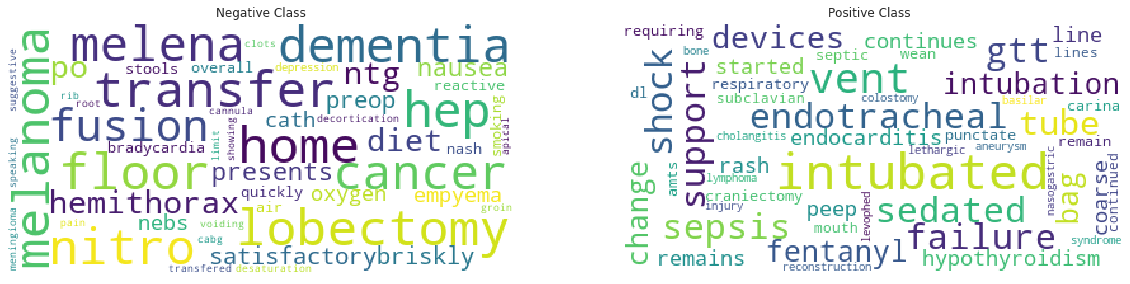

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), clf.coef_[0]/clf.coef_[0].sum(), n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Negative Class')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Positive Class')

### ICU Discharge

In [9]:
df = set_two_splits(discharge_df.copy(), 'test', seed=seed)
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['scispacy_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['scispacy_note'])
y_train = df.loc[(df['split'] == 'train')]['discharge_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['discharge_label'].to_numpy()

In [10]:
clf = LogisticRegression(dual=True, class_weight='balanced', solver='liblinear', C=1.5, multi_class='ovr')
clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plot_thresh_range(ax, y_test, prob, 0.3, 0.7, 25)

In [11]:
args.discharge_threshold = 0.48
y_pred = (prob > args.discharge_threshold).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
prevalence = (fn+tp)/(tn+fp+fn+tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'prevalence': np.round(prevalence, 3),  
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.726
specificity,0.703
ppv,0.592
npv,0.812
f1,0.652
auroc,0.791
prevalence,0.373


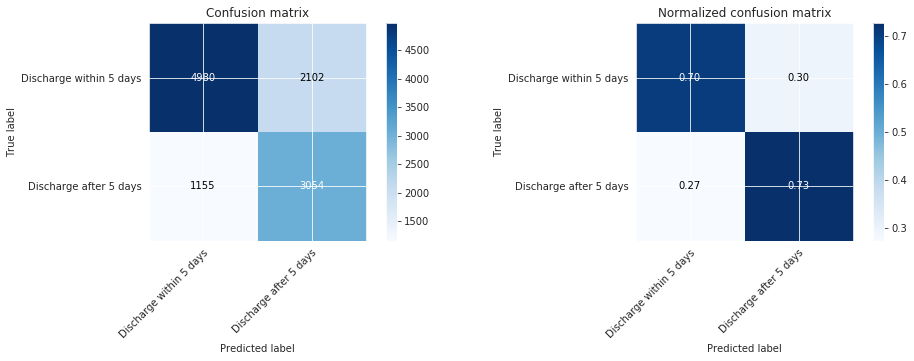

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_confusion_matrix(ax[0], cm, classes=['Discharge within 5 days', 'Discharge after 5 days'], normalize=False, title='Confusion matrix')
plot_confusion_matrix(ax[1], cm, classes=['Discharge within 5 days', 'Discharge after 5 days'], normalize=True,\
                      title='Normalized confusion matrix')
plt.show()

Text(0.5, 1.0, 'Positive Class')

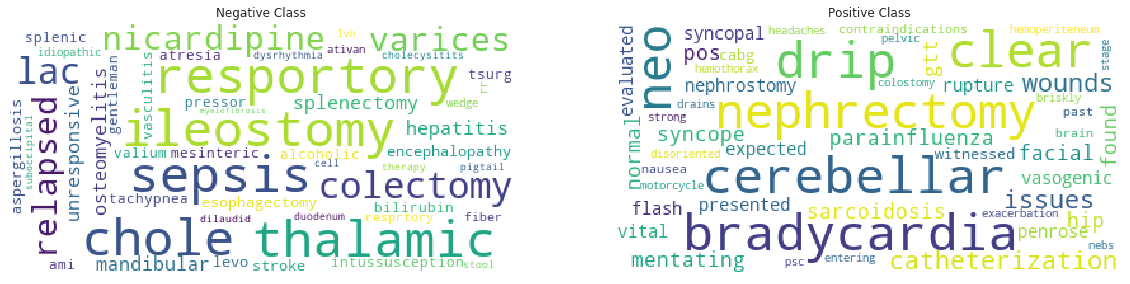

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), clf.coef_[0]/clf.coef_[0].sum(), n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Negative Class')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Positive Class')

## 100 Seed Run

In [14]:
def run(task, ori_df, threshold):
  preds = []
  targs = []
  probs = []
  print(f"Running for task: {task}")

  for seed in range(args.start_seed, args.start_seed + 100):
    if seed % 10 == 0:
      print(f"Running classifier with seed {seed}")
    df = set_two_splits(ori_df.copy(), 'test', seed=seed)
    vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, ngram_range=(2,2))

    x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['scispacy_note'])
    x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['scispacy_note'])

    y_train = df.loc[(df['split'] == 'train')][f'{task}_label'].to_numpy()
    y_test = df.loc[(df['split'] == 'test')][f'{task}_label'].to_numpy()
    targs.append(y_test)

    clf = LogisticRegression(dual=True, class_weight='balanced', solver='liblinear', C=1.5)
    clf.fit(x_train, y_train)  
    pickle.dump(clf, open(args.modeldir/f'{task}_seed_{seed}.pkl', 'wb'))

    pos_prob = clf.predict_proba(x_test)[:, 1]
    probs.append(pos_prob)

    y_pred = (pos_prob > threshold).astype(np.int64)
    preds.append(y_pred)

  with open(args.workdir/f'{task}_preds.pkl', 'wb') as f:
    pickle.dump(targs, f)
    pickle.dump(preds, f)
    pickle.dump(probs, f)

In [15]:
run('imminent', imminent_df, args.imminent_threshold)
run('discharge', discharge_df, args.discharge_threshold)

Running for task: imminent
Running classifier with seed 130
Running classifier with seed 140
Running classifier with seed 150
Running classifier with seed 160
Running classifier with seed 170
Running classifier with seed 180
Running classifier with seed 190
Running classifier with seed 200
Running classifier with seed 210
Running classifier with seed 220
Running for task: discharge
Running classifier with seed 130
Running classifier with seed 140
Running classifier with seed 150
Running classifier with seed 160
Running classifier with seed 170
Running classifier with seed 180
Running classifier with seed 190
Running classifier with seed 200
Running classifier with seed 210
Running classifier with seed 220


## Metrics

Taken from [here](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/):

1. Prevalence: `(fn + tp) / total`
2. Sensitivity: AKA recall, true positive rate `tp / (tp + fn)`
3. Specificity: AKA true negative rate `tn / (tn + fp)`
4. Positive Predictive Value (PPV): AKA precision `tp / (tp + fp)`
5. Negative Predictive Value (NPV): `tn / (tn + fn)`

In [16]:
with open(args.workdir/f'imminent_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

bam_imminent = BinaryAvgMetrics(targs, preds, probs)

with open(args.workdir/f'discharge_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

bam_discharge = BinaryAvgMetrics(targs, preds, probs)

fnames_imminent = [f'imminent_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]
fnames_discharge = [f'discharge_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]

In [21]:
bam_imminent.get_avg_metrics(conf=0.95)

,Lower,Mean,Upper
sensitivity,89.2,89.3,89.5
specificity,62.1,62.2,62.3
ppv,42.0,42.2,42.3
auroc,84.2,84.2,84.3
npv,94.9,95.0,95.0
f1,57.2,57.3,57.4


In [27]:
get_best_model(bam_imminent, fnames_imminent)

,Value,Model File
sensitivity,0.911982,imminent_seed_162.pkl
specificity,0.637443,imminent_seed_129.pkl
ppv,0.441491,imminent_seed_187.pkl
auroc,0.854318,imminent_seed_187.pkl
npv,0.959168,imminent_seed_162.pkl
f1,0.592101,imminent_seed_187.pkl


In [25]:
bam_discharge.get_avg_metrics(conf=0.95)

,Lower,Mean,Upper
sensitivity,71.3,71.4,71.5
specificity,63.5,63.7,63.8
ppv,53.0,53.1,53.2
auroc,74.8,74.9,75.0
npv,79.3,79.4,79.5
f1,60.8,60.9,61.0


In [28]:
get_best_model(bam_discharge, fnames_discharge)

,Value,Model File
sensitivity,0.729223,discharge_seed_207.pkl
specificity,0.649811,discharge_seed_197.pkl
ppv,0.542758,discharge_seed_165.pkl
auroc,0.756583,discharge_seed_134.pkl
npv,0.805817,discharge_seed_190.pkl
f1,0.619861,discharge_seed_190.pkl


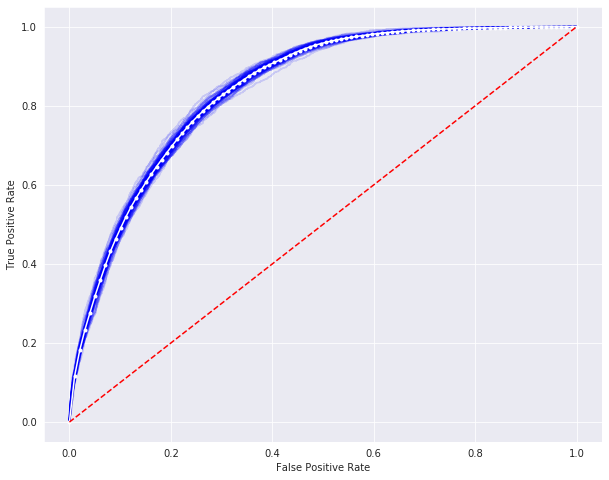

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam_imminent.targs, bam_imminent.probs)

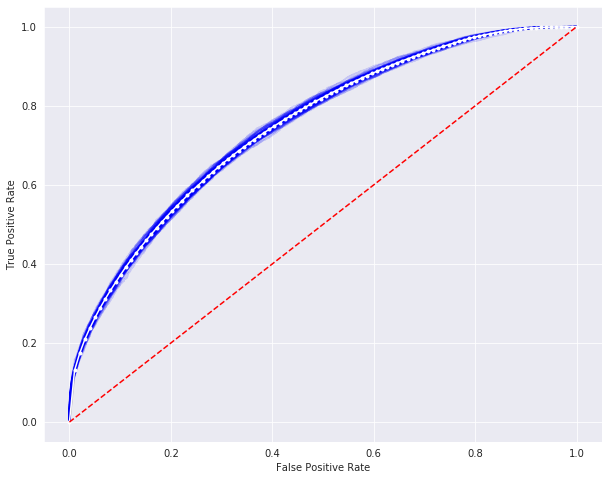

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam_discharge.targs, bam_discharge.probs)

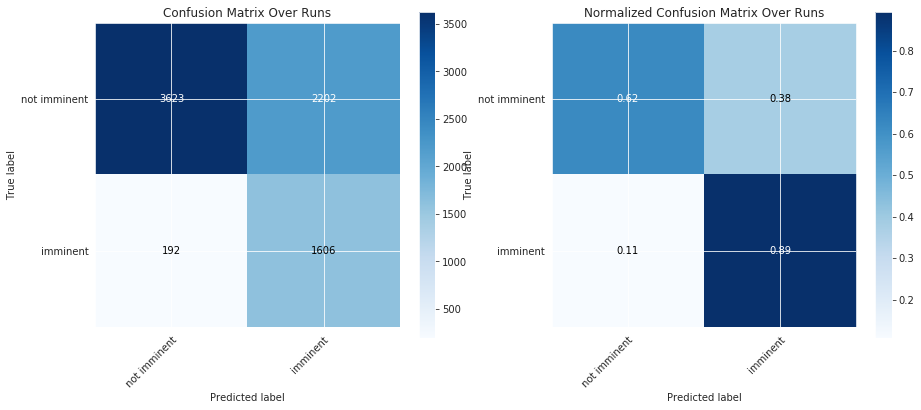

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam_imminent.cm_avg, classes=['not imminent', 'imminent'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam_imminent.cm_avg, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()

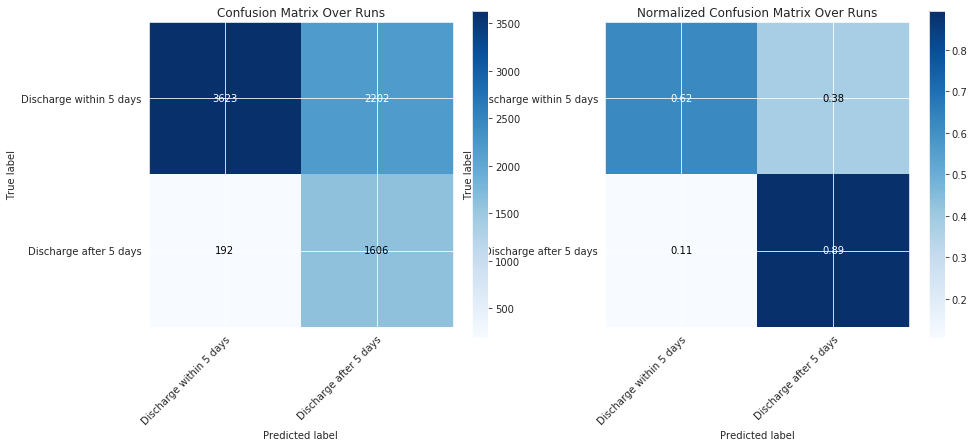

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam_imminent.cm_avg, classes=['Discharge within 5 days', 'Discharge after 5 days'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam_imminent.cm_avg, classes=['Discharge within 5 days', 'Discharge after 5 days'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()

## Full Data

In [ ]:
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols)

imminent_df = ori_df.loc[(ori_df['imminent_label'] != -1)][['scispacy_note', 'imminent_label']].reset_index()
discharge_df = ori_df[['scispacy_note', 'discharge_label']].reset_index()

### Imminent ICU Admission

In [34]:
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x = vectorizer.fit_transform(imminent_df['scispacy_note'])
y = imminent_df['imminent_label'].to_numpy()
clf = LogisticRegression(dual=True, class_weight='balanced', solver='liblinear', C=1.5)
clf.fit(x, y)

LogisticRegression(C=1.5, class_weight='balanced', dual=True,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
with open(args.workdir/'imminent_model.pkl', 'wb') as f:
  pickle.dump(clf, f)
  pickle.dump(vectorizer.vocabulary_, f)

In [37]:
interval_hours=12
starting_day = -20
ending_day = -1

In [39]:
imminent_df['prob'] = clf.predict_proba(vectorizer.fit_transform(imminent_df['scispacy_note']))[:, 1]

KeyError: 'relative_charttime'

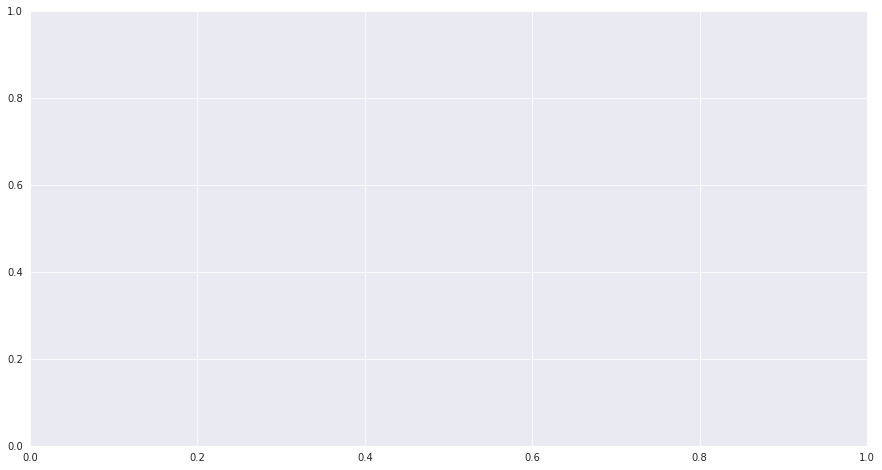

In [41]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df, args.imminent_threshold, starting_day, ending_day, interval_hours)

TypeError: plot_prob() got an unexpected keyword argument 'cutoff'

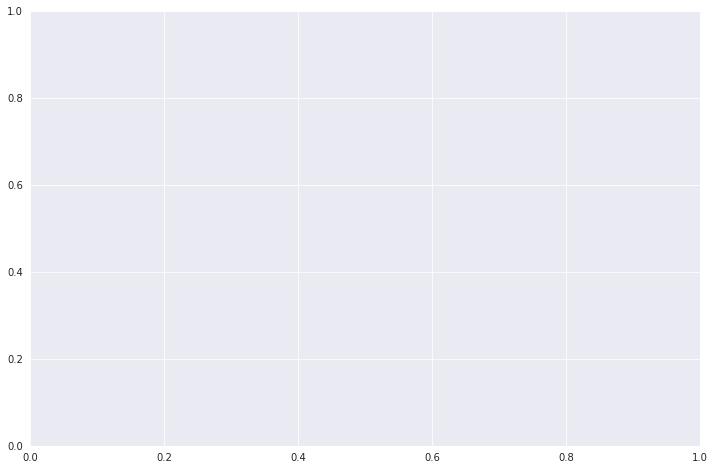

In [36]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_prob(ax, df, args.imminent_threshold, cutoff=20, interval=12)